In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import MolFromSmiles, MACCSkeys
rdDepictor.SetPreferCoordGen(True)
# sns.set_context('notebook')
# sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [2]:
# scramble them
# Reduced for CI!
# soldata = soldata.sample(frac=0.01, random_state=0).reset_index(drop=False)
# soldata.head()
len(soldata.SMILES)

9982

In [3]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]
len(selfies_list)

9982

In [4]:
vocab = list(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
print('Vocab size', len(vocab))

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result
def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
# assert so == s

Vocab size 206
selfies: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C].[Br-expl]
selfies2ints: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 92, 130, 131, 131, 130, 131, 131, 131, 17]
ints2selfes: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C][Br-expl]


In [5]:
#creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
        
config = Config(vocab_size=len(vocab), 
                example_number=len(selfies_list), 
                batch_size=16, 
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

In [6]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values))
# now split into val, test, train and batch
N = len(data)  
print(N)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

9982


In [7]:
! nvidia-smi

Thu Sep 16 14:39:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   29C    P0    35W / 250W |    457MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [8]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         52736     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 217,601
Trainable params: 217,601
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

In [10]:
model.save('solubility-rnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: solubility-rnn/assets


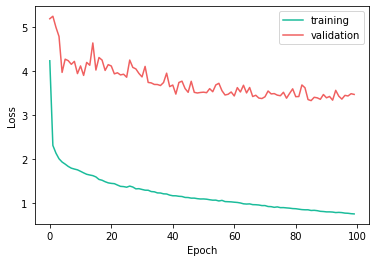

In [11]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

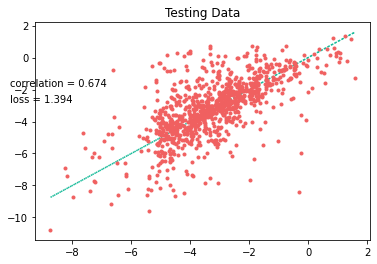

In [12]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) - 7, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) - 7, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [13]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [14]:
predictor_function([], ['[C][#S-expl]', '[C]'])

array([        nan, -1.44771004])

In [15]:
stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)

🤘Done🤘: 100%|██████████| 3853.0/3853 [00:30<00:00, 127.38it/s]              


In [16]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator

desc_type = 'MACCS'
space_tstats, beta = exmol.lime_explain(space, descriptor_type=desc_type)

In [17]:
from collections import OrderedDict
feature_importance = {a:b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats)}
feature_importance = dict(sorted(feature_importance.items(),
             key=lambda item: abs(item[1]),
             reverse=True))
#Fitted space important features
feature_importance

{'Is there an oxygen with at least two chain bonds?': -5.541289309960799,
 'Fragments?': -4.6812420267289045,
 'Is there an atom bonded to another atom by a ring bond and bonded to a oxygen by a chain bond?': 4.541085727696789,
 'Is there a 6M Ring?': -4.278950510579186,
 'Is it an element from Group IIIA (B...)?': -4.2073454978214375,
 'Is it an atom in a ring?': 4.111655205878238,
 'Is a Carbon bonded to Oxygen by a single bond?': -4.0742410482009355,
 'Is there a heteroatom bonded to an oxygen by a single or double bond?': -3.380641072131053,
 'Are there more than 2 methyl groups?': 3.065576154895573,
 'Is there a Br?': -2.7149012243149864,
 'Is there more than one methyl group?': -2.522534099511072,
 'Is there a methylene carbon bonded to a nitrogen and another atom?': -2.511700157395193,
 'Is there a N?': -2.5077936796510403,
 'Are there two methylene carbons bonded by a single bond? Or are there two atoms separated by two methylene carbons?': -2.4771614605727503,
 'Is there a nit

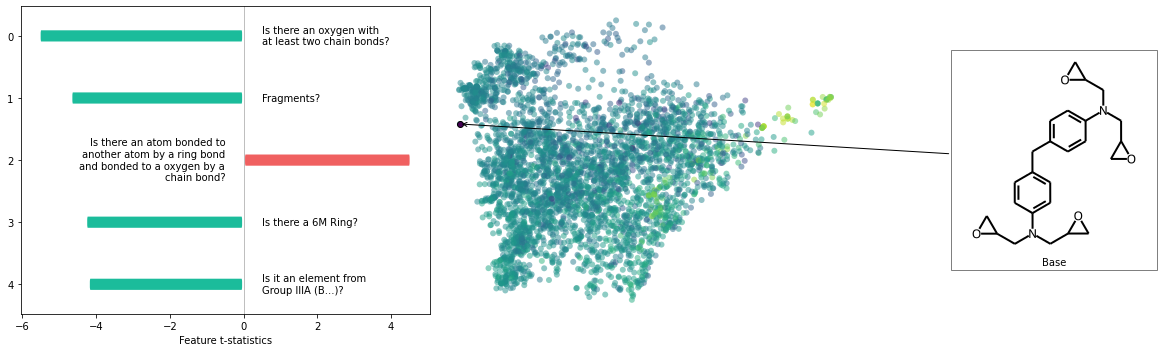

In [18]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

fig = plt.figure(figsize=(12,5))
# ax_dict = fig.subplot_mosaic('BBBAA')
ax_dict = fig.subplot_mosaic('AAABBB')

r = Rectangle((0, 0), 1, 1)
# cmap = plt.get_cmap("gist_rainbow", 20)
# colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

t = list(feature_importance.values())[:5]
colors = []
for ti in t:
    if ti < 0:
        colors.append(color_cycle[0])
    if ti > 0:
        colors.append(color_cycle[1])

keys = list(feature_importance.keys())[:5]

# bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
bar1 = ax_dict['A'].barh(range(len(t)), t, color=colors, height=0.5)
new_patches = []
for patch in reversed(ax_dict['A'].patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.040,rounding_size=0.015",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax_dict['A'].add_patch(patch)

count = 1
for rect, ti, k in zip(bar1, t, keys):
    y = rect.get_y() + rect.get_height()/2.
    if len(k) > 60:
        k = textwrap.fill(k, 30)
    elif len(k) > 30:
        k = textwrap.fill(k, 25)
    if ti < 0:
        x = 0.5
        ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
        count+=1
    else:
        x = -0.5
        ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
        count+=1
    
    
ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
ax_dict['A'].invert_yaxis()
ax_dict['A'].set_xlabel('Feature t-statistics')
# ax_dict['A'].get_yaxis().set_ticks([])
svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B'])
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
if desc_type=='MACCS':
    plt.savefig('rnn-solibility-maccs.svg', dpi=300, bbox_inches='tight')
if desc_type=='Classic':
    plt.savefig('rnn-solibility-classic.svg', dpi=300, bbox_inches='tight')

In [19]:
exps = exmol.rcf_explain(space, 0.5, nmols=3)
exps = exmol.get_descriptors(exps)
# get tstats as a difference from base
for e in exps:
    if e.is_origin:
        base = e.descriptors.descriptors
        e.descriptors.tstats = np.subtract(base, e.descriptors.descriptors) * beta
    else:
        e.descriptors.tstats = np.subtract(base, e.descriptors.descriptors) * beta
        print(np.max(e.descriptors.tstats), np.min(e.descriptors.tstats))

on_bits = list(np.concatenate([[i for i in range(1,167) if e.descriptors.tstats[i] != 0]
                               for e in exps if e.is_origin==False]).flat)

0.7629652141019503 0.0
0.1374209045641101 -0.29676129431005005


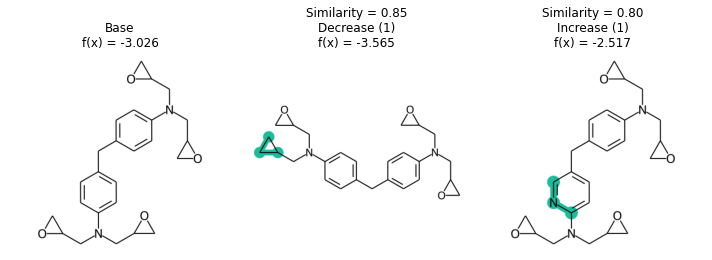

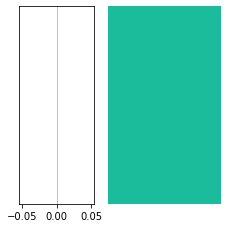

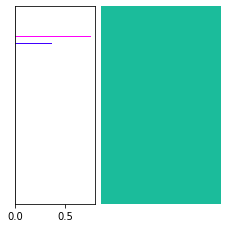

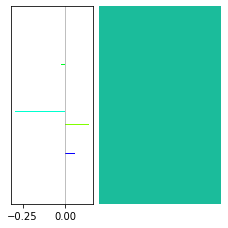

In [20]:
import skunk
%matplotlib inline
fkw = {'figsize': (10,11)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)
# exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(300,200), offset=1, plot_descriptors=False)
svg = exmol.insert_svg(exps=exps, descriptors=True)
plt.savefig('rnn-simple.svg', dpi=180)

🤘Done🤘: 100%|██████████| 2352.0/2352 [00:12<00:00, 192.97it/s]            


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

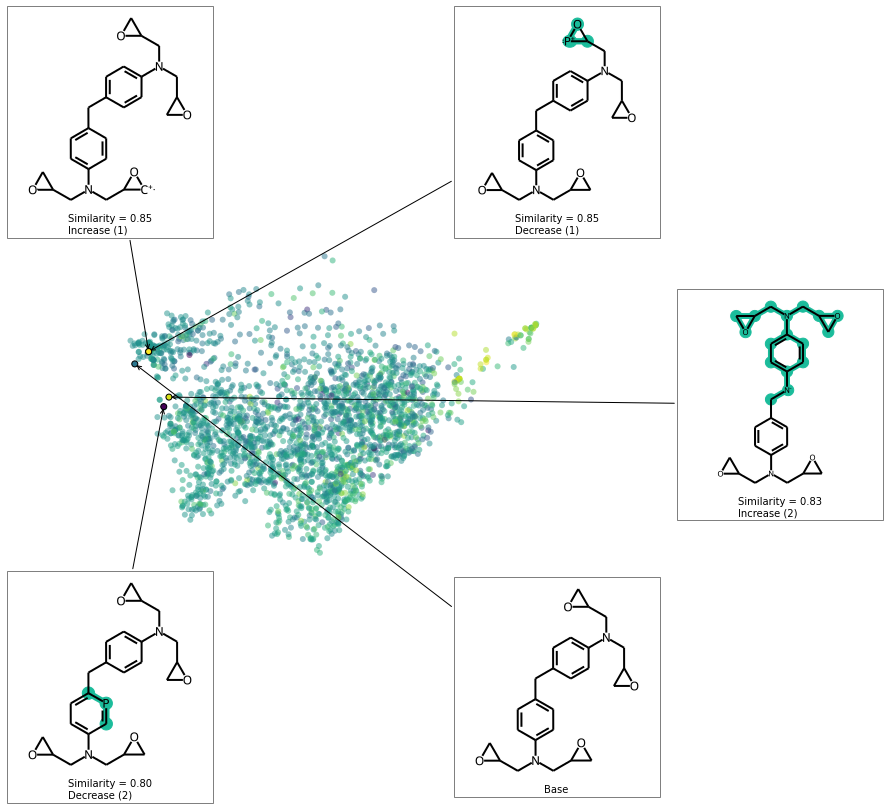

In [21]:
space = exmol.sample_space(soldata.SMILES[4], predictor_function, preset='wide')
exps = exmol.rcf_explain(space, 0.5)
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(200,200), offset=1)
plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rnn-wide.png', bbox_inches='tight', dpi=180)

## Figure showing effect of mutation number and Alphabet


In [ ]:
exps = []
spaces = []
for i in [1,3,5]:
    stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
    space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    spaces.append(space)
    e = exmol.rcf_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Mutations = {i}'
            exps.append(ei)
            break

In [ ]:
fkw = {'figsize': (10, 4)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-mutations.png', bbox_inches='tight', dpi=180)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    axs[i].hist([e.similarity for e in spaces[i][1:]], bins=99,edgecolor='none')
    axs[i].set_title(f'Mutations = {n}')
    axs[i].set_xlim(0,1)
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [ ]:
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()

alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

exps = []
for l,a in alphs.items():
    stoned_kwargs={'num_samples': 2500//2, 'alphabet':a, 'max_mutations': 2}
    space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    e = exmol.rcf_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Alphabet = {l}'
            exps.append(ei)
            break

In [ ]:
fkw = {'figsize': (10, 4)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-alphabets.png', bbox_inches='tight', dpi=180)